In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

import pandas as pd
import os
import sys
from pathlib import Path

import numpy as np

In [74]:
home = str(Path.home())
data = pd.read_csv(home+"/downloads/NYPD_Hate_Crimes_20240917.csv")

In [75]:
data[~data['Arrest Id'].isna()]

,Full Complaint ID,Complaint Year Number,Month Number,Record Create Date,Complaint Precinct Code,Patrol Borough Name,County,Law Code Category Description,Offense Description,PD Code Description,Bias Motive Description,Offense Category,Arrest Date,Arrest Id
1761,201901012297417,2019,6,06/07/2019,10,PATROL BORO MAN SOUTH,NEW YORK,FELONY,MISCELLANEOUS PENAL LAW,AGGRAVATED HARASSMENT 1,ANTI-BLACK,Race/Color,NaN,M31697999
1762,201901312988617,2019,11,11/03/2019,13,PATROL BORO MAN SOUTH,NEW YORK,FELONY,MISCELLANEOUS PENAL LAW,AGGRAVATED HARASSMENT 1,ANTI-MALE HOMOSEXUAL (GAY),Unclassified,NaN,M34672420
1763,201901712382117,2019,8,08/08/2019,17,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,"MENACING,UNCLASSIFIED",ANTI-MULTI-RACIAL GROUPS,Race/Color,NaN,M31713881
1764,201901812274317,2019,3,03/16/2019,18,PATROL BORO MAN SOUTH,NEW YORK,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaN,M31684401
1765,201901812890617,2019,10,10/05/2019,18,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaN,M31719199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,202401412419617,2024,3,03/09/2024,14,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-ASIAN,Race/Color,NaN,M36684260
3074,202401412419617,2024,3,03/09/2024,14,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-ASIAN,Race/Color,NaN,M36684674
3075,202401412419717,2024,3,03/09/2024,14,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-ASIAN,Race/Color,NaN,M36684675
3076,202401712080417,2024,1,01/08/2024,17,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-JEWISH,Religion/Religious Practice,NaN,M36673135


In [76]:
data['Arrested'] = np.where(~data['Arrest Id'].isna(),1,0)

In [77]:
data['Bias Motive Description'].unique()

array(['ANTI-JEWISH', 'ANTI-WHITE', 'ANTI-TRANSGENDER',
       'ANTI-MALE HOMOSEXUAL (GAY)', 'ANTI-BLACK', 'ANTI-ASIAN',
       'ANTI-FEMALE HOMOSEXUAL (LESBIAN)', 'ANTI-MUSLIM', 'ANTI-HISPANIC',
       'ANTI-GENDER NON-CONFORMING', 'ANTI-ARAB',
       'ANTI-PHYSICAL DISABILITY', 'ANTI-OTHER ETHNICITY',
       'ANTI-CATHOLIC', 'ANTI-LGBT (MIXED GROUP)', 'ANTI-OTHER RELIGION',
       'ANTI-RELIGIOUS PRACTICE GENERALLY', 'ANTI-PROTESTANT',
       'ANTI-BUDDHIST', 'ANTI-FEMALE', 'ANTI-SIKH',
       'ANTI-JEHOVAHS WITNESS', 'ANTI-EASTERN ORTHODOX',
       'ANTI-MULTI-RACIAL GROUPS', 'ANTI-HINDU', 'ANTI-MORMON',
       '60 YRS AND OLDER', 'ANTI-MALE'], dtype=object)

In [85]:
features = [
    'Patrol Borough Name',
    'Law Code Category Description',
    'Offense Description',
    'Bias Motive Description'
]
target = 'Arrested'

In [86]:

onehot_encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
onehot_features = [i for i in features]

transformer = ColumnTransformer(
    transformers=[
        ('onehot',onehot_encoder,onehot_features)
    ]
)

model = Pipeline(
    steps=[
        ('transformer',transformer),
        ('learner',LogisticRegression())
    ]
)

In [87]:
model.fit(data[features],data[target])

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Patrol Borough Name',
                                                   'Law Code Category '
                                                   'Description',
                                                   'Offense Description',
                                                   'Bias Motive '
                                                   'Description'])])),
                ('learner', LogisticRegression())])

In [88]:
inner_model = model['learner']

In [89]:
coefs = inner_model.coef_
coefs_df = pd.DataFrame(
    {'coefs':coefs[0],
     'feats':model['transformer'].get_feature_names_out()}
)
coefs_df['factor'] = np.exp(coefs_df['coefs'])

In [92]:
list(coefs_df.sort_values(by='factor',ascending=True).head(30)['feats'].values)

['onehot__Offense Description_MISCELLANEOUS PENAL LAW',
 'onehot__Offense Description_CRIMINAL MISCHIEF & RELATED OF',
 'onehot__Law Code Category Description_MISDEMEANOR',
 'onehot__Bias Motive Description_ANTI-PROTESTANT',
 'onehot__Law Code Category Description_VIOLATION',
 'onehot__Offense Description_HARRASSMENT 2',
 'onehot__Offense Description_GRAND LARCENY',
 'onehot__Bias Motive Description_ANTI-JEWISH',
 'onehot__Bias Motive Description_ANTI-BUDDHIST',
 'onehot__Bias Motive Description_ANTI-RELIGIOUS PRACTICE GENERALLY',
 'onehot__Law Code Category Description_INVESTIGATION',
 'onehot__Offense Description_INVESTIGATIONS/COMPLAINTS ONLY',
 'onehot__Offense Description_PETIT LARCENY',
 'onehot__Offense Description_OFF. AGNST PUB ORD SENSBLTY &',
 'onehot__Bias Motive Description_ANTI-GENDER NON-CONFORMING',
 'onehot__Patrol Borough Name_PATROL BORO BRONX',
 'onehot__Bias Motive Description_ANTI-MORMON',
 'onehot__Bias Motive Description_ANTI-MALE HOMOSEXUAL (GAY)',
 'onehot__Bi

In [67]:
predictions = model.predict_proba(data[features])

In [69]:
predictions[:,1]

array([0.22162217, 0.20229985, 0.20229985, ..., 0.75483071, 0.60224927,
       0.60224927])

In [70]:
data[target]

0       0
1       0
2       0
3       0
4       0
       ..
3073    1
3074    1
3075    1
3076    1
3077    1
Name: Arrested, Length: 3078, dtype: int32

In [71]:
import matplotlib.pyplot as plt

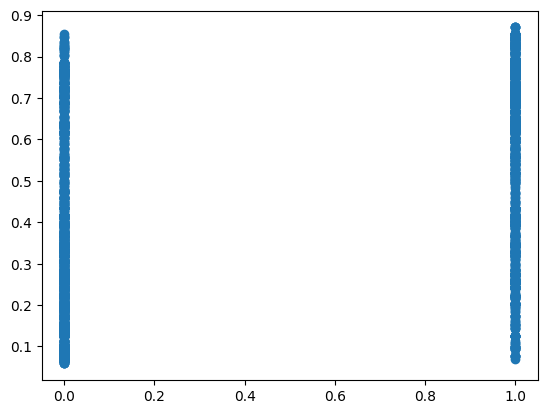

In [72]:
plt.scatter(data[target],predictions[:,1])